# Directionaly of the adaptive response

We will make use of the Hug and Gaut methodology to determine the directionaly of adaptation.

In [54]:
#Libraries
library('tidyverse')
library(rlang)


#Functions
compare_to_ancestral=function(data,T_ref, T_test,refname){
    #Empty dataframe
    comparison = data.frame(clone = character(), median=numeric(),pval=numeric(),logistest=character(),
                             referencia=numeric(),PC=character())
    #Set the two datasets to be compared
    datatest=subset(data,data$Condition==T_test) #Test temperature
    dataref=subset(data,data$Condition==T_ref) #Reference temperature    
    pcs = colnames(data)[9:12]
    #Loop
    for (i in 1:length(pcs)) {
        pcs_t = pcs[i]
        #Reference medians
        median_PC = datatest %>% select(clone,Condition,pcs_t) %>% 
        group_by(clone) %>% summarise(median=median(!!sym(pcs_t))) %>% 
        add_column(pval=0,logi_test=0,referencia = T_ref,PC=pcs_t) 
        median_PCref = dataref %>% select(clone,Condition,pcs_t) %>% 
        group_by(clone) %>% summarise(median=median(!!sym(pcs_t))) %>% 
        add_column(pval=0,logi_test=0,referencia = T_ref,PC=pcs_t) 
        #For each component
        for (j in 1:nrow(median_PC)) {
           nom=levels(factor(median_PC$clone[j]))
           temporal = datatest %>%  filter(clone==nom) %>% select(pcs_t)
           temporal_ref = dataref %>%  filter(clone==refname) %>% select(pcs_t)
           ref_mitjana = median_PCref %>% filter(clone == refname) %>% select(median)
           test_mitjana = median_PC %>% filter(clone == nom) %>% select(median)
           if(test_mitjana<ref_mitjana) {
                testtype="less"
                    } else if(test_mitjana>ref_mitjana) {
                        testtype="greater"
                        } else {
                        testtype="two.sided"
                        }
         median_PC$logi_test[j]=testtype
         test=t.test(temporal, y = temporal_ref,
            alternative = testtype,
            mu = 0, paired = FALSE, var.equal=FALSE, exact = TRUE, correct = TRUE,
            conf.int = FALSE, conf.level = 0.95)
          median_PC$pval[j]=test$p.value
        
        }
        comparison=rbind(comparison,median_PC)
    
    }
      
return(comparison)
}

## Select the dataset

In [55]:
#Read the PCA transformmed data
data606=read.csv('606_scores.csv')
data607=read.csv('607_scores.csv')

## Format columns
data606$Condition=as.factor(data606$Condition)
data606$Treatment=as.factor(data606$Treatment)
data606$Name=as.factor(data606$Name)
data607$Condition=as.factor(data607$Condition)
data607$Treatment=as.factor(data607$Treatment)
data607$Name=as.factor(data607$Name)
data606$clone = data606$Name
data607$clone = data607$Name

## Get the comparisons

In [114]:
#comparisons
data = data606
T_ref = 37
T_test = 15
refname = "606P"
comp_file=compare_to_ancestral(data, T_ref, T_test ,refname)
file_name=paste(refname,T_test,"vs",T_ref,".csv",sep= "_")
write.csv(comp_file,file_name)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



### Correction of type I error and directionality assessment

In [144]:
#To compare
T_ref = 15
T_test = 15

#Load the data and the reference set
data_name=paste(refname,T_test,"vs",T_ref,".csv",sep= "_")
data=read.csv(data_name)
alpha=0.05
control_name=paste(refname,T_test,"vs","37",".csv",sep= "_")
control=read.csv(control_name)
#Rename Columns
colnames(control)[4]="pvalref"
colnames(data)[4]="pvaltest"
data$logi_test=as.character(data$logi_test)
control$logi_test=as.character(control$logi_test)
#Multiple comparison correction
control$pvalref=p.adjust(control$pvalref,method="fdr")
data$pvaltest=p.adjust(data$pvaltest,method="fdr")
data$logi_test[data$pvaltest>=alpha] = 'equal'
control$logi_test[control$pvalref>=alpha] = 'equal'

#Add PCdir to data
references = control %>% filter((control$clone==refname))
row.names(references)=references$PC
data=data %>%  mutate(PCdir=references[as.character(PC),'logi_test'])

#filter controls
data = data %>% filter(!(data$clone==refname))
control = control %>% filter(!(control$clone==refname))
data$comparison=""

# Test Classifyier
for (i in 1:nrow(data)) {

	if (control$logi_test[i]=="less" && data$logi_test[i]=="greater" && data$PCdir[i]=="less") {
		data$comparison[i]="Partially Restored"} 
	if(control$logi_test[i]=="greater" && data$logi_test[i]=="less"  && data$PCdir[i]=="greater") {
		data$comparison[i]="Partially Restored"}
	if(control$logi_test[i]=="less" && data$logi_test[i]=="less" && data$PCdir[i]=="less") {
		data$comparison[i]="Reinforced"}
	if(control$logi_test[i]=="greater" && data$logi_test[i]=="greater" && data$PCdir[i]=="greater") {
		data$comparison[i]="Reinforced"}
	if(control$logi_test[i]=="less" && data$logi_test[i]=="less" && data$PCdir[i]=="greater") {
		data$comparison[i]="Over-restored"}
	if(control$logi_test[i]=="greater" && data$logi_test[i]=="greater" && data$PCdir[i]=="less") {
		data$comparison[i]="Over-restored"}
	if(control$logi_test[i]=="greater" && data$logi_test[i]=="equal" && data$PCdir[i]=="greater") {
		data$comparison[i]="Unrestored"}
	if(control$logi_test[i]=="less" && data$logi_test[i]=="equal"&& data$PCdir[i]=="less") {
		data$comparison[i]="Unrestored"}
	if(control$logi_test[i]=="equal" && data$logi_test[i]=="greater"  && data$PCdir[i]=="less") {
		data$comparison[i]="Restored"}
	if(control$logi_test[i]=="equal" && data$logi_test[i]=="less"  && data$PCdir[i]=="greater") {
		data$comparison[i]="Restored"}
	if(control$logi_test[i]=="less" && data$logi_test[i]=="less"  && data$PCdir[i]=="equal") {
		data$comparison[i]="Novel"}
    if(control$logi_test[i]=="greater" && data$logi_test[i]=="greater"  && data$PCdir[i]=="less") {
		data$comparison[i]="Novel"}
    if(control$logi_test[i]=="equal" && data$logi_test[i]=="less"  && data$PCdir[i]=="equal") {
		data$comparison[i]="Novel"}
	if(control$logi_test[i]=="greater" && data$logi_test[i]=="greater"  && data$PCdir[i]=="equal") {
		data$comparison[i]="Novel"}
    	if(control$logi_test[i]=="less" && data$logi_test[i]=="less"  && data$PCdir[i]=="greater") {
		data$comparison[i]="Novel"}
    	if(control$logi_test[i]=="less" && data$logi_test[i]=="less"  && data$PCdir[i]=="greater") {
		data$comparison[i]="Novel"}
    if(control$logi_test[i]=="less" && data$logi_test[i]=="equal"  && data$PCdir[i]=="equal") {
		data$comparison[i]="Uninformative"}
    if(control$logi_test[i]=="greater" && data$logi_test[i]=="equal"  && data$PCdir[i]=="equal") {
		data$comparison[i]="Uninformative"}
	if(control$logi_test[i]=="equal" && data$logi_test[i]=="equal"  && data$PCdir[i]=="equal") {
		data$comparison[i]="Uninformative"}
    if(control$logi_test[i]=="equal" && data$logi_test[i]=="equal"  && data$PCdir[i]=="less") {
		data$comparison[i]="Uninformative"}
    if(control$logi_test[i]=="equal" && data$logi_test[i]=="equal"  && data$PCdir[i]=="greater") {
		data$comparison[i]="Uninformative"}
	}

# save
data$Name = data$clone
data$comparison = factor(data$comparison, levels = c(
'Unrestored','Partially Restored','Reinforced','Uninformative','Novel','Restored'))
restore =  inner_join(data,data606, by = "Name")
#Save
file_name=paste(refname,T_test,"directionality.csv",sep= "_")
write.csv(restore,file_name)

In [145]:
files = list.files(pattern = "*directionality.csv")
direccio = read.csv(files[1])

for (i in 2:length(files)){
    directe = read.csv(files[i]) 
    direccio = rbind(direccio,directe)
}

head(direccio)

,X,X.x,clone.x,median,pvaltest,logi_test,referencia,PC,PCdir,comparison,⋯,Strain,Treatment,Condition,Strategy,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,clone.y
,<int>,<int>,<fct>,<dbl>,<dbl>,<fct>,<int>,<fct>,<fct>,<fct>,⋯,<int>,<fct>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,1,2,F606-1,-1.979702,0.2398361,equal,15,Dim.1,less,Unrestored,⋯,606,Fast,15,Specialist,-2.09859797,-0.5167400,-0.445651077,-0.09239028,-0.107439405,F606-1
2,2,2,F606-1,-1.979702,0.2398361,equal,15,Dim.1,less,Unrestored,⋯,606,Fast,15,Specialist,-1.97970187,-0.5871623,0.106600260,-0.09198536,-0.143172208,F606-1
3,3,2,F606-1,-1.979702,0.2398361,equal,15,Dim.1,less,Unrestored,⋯,606,Fast,15,Specialist,-1.94235100,-0.6078040,-0.133470170,0.05152904,-0.096204017,F606-1
4,4,2,F606-1,-1.979702,0.2398361,equal,15,Dim.1,less,Unrestored,⋯,606,Fast,37,Specialist,0.09923414,0.7208679,0.162424283,-0.10569192,-0.063433896,F606-1
5,5,2,F606-1,-1.979702,0.2398361,equal,15,Dim.1,less,Unrestored,⋯,606,Fast,37,Specialist,-0.14653926,0.8323837,-0.279742594,-0.15824209,-0.236343633,F606-1
6,6,2,F606-1,-1.979702,0.2398361,equal,15,Dim.1,less,Unrestored,⋯,606,Fast,37,Specialist,0.02176042,0.8157626,0.008838458,-0.16449198,0.003878926,F606-1


In [148]:
pdf("BiologRestoration_byTretment.pdf")
ggplot(direccio) + aes(x = PC, fill =comparison)+
  geom_bar(position = "fill")+ ylab("Relative Abundance") + 
  xlab("Environment")+facet_grid(Treatment~Strain)
dev.off()

pdf 
  2

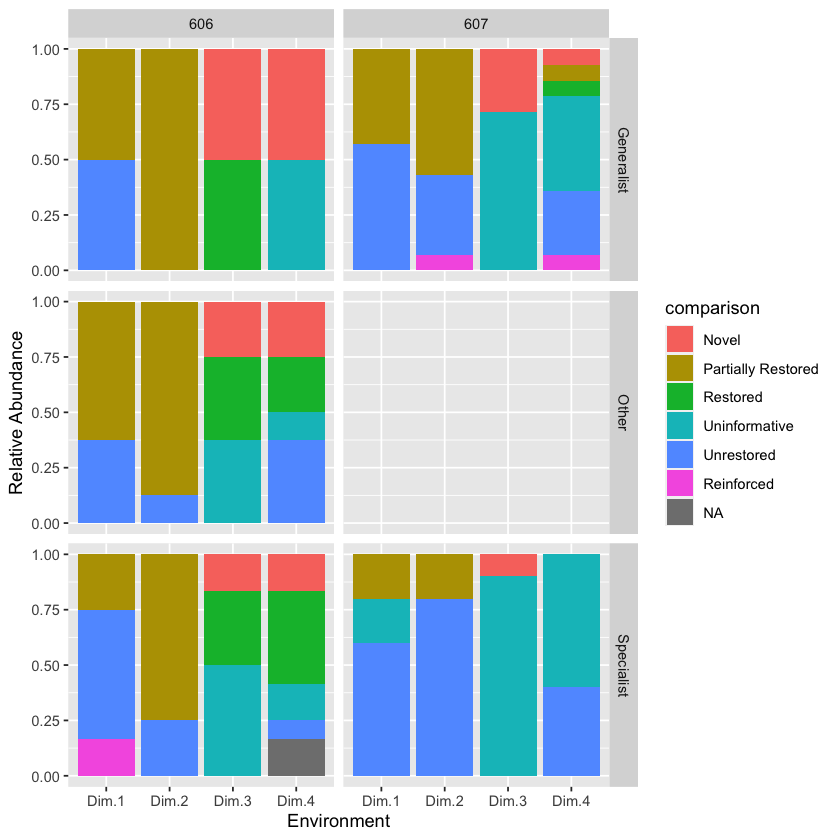

In [150]:
#pdf("BiologRestoration_byTretment.pdf")
ggplot(direccio) + aes(x = PC, fill =comparison)+
  geom_bar(position = "fill")+ ylab("Relative Abundance") + 
  xlab("Environment")+facet_grid(Strategy~Strain)
#dev.off()